# Analyzing tweets about Korean Dramas

In [1]:
import json
import emojis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Reading the csv into a dataframe
df = pd.read_csv('kdrama_tweets')

#First five rows of the dataframe 
df.head()

,date_created,tweet_text,tweet_id,hashtags,user_id,location,retweeted,lang,retweeted_text,retweeted_hashtags
0,Sat Jan 30 22:54:16 +0000 2021,RT @sakuratoffee: Just finished Memories of th...,1355650566492463104,['Netflix'],955271515959975936,"Dublin City, Ireland",True,en,Just finished Memories of the Alhambra on #Net...,['Netflix']
1,Sat Jan 30 22:36:21 +0000 2021,Just finished Memories of the Alhambra on #Net...,1355646057657622530,['Netflix'],755854750948663297,"Lewisham, London",False,en,NaN,NaN
2,Sat Jan 30 21:43:19 +0000 2021,Damn #theuncannyencounter how can you do that ...,1355632713399562244,"['theuncannyencounter', 'netflix', 'koreandram...",863035493423951873,Here,False,en,NaN,NaN
3,Sat Jan 30 20:33:08 +0000 2021,RT @s_l1485: 👋🏻👋🏻 HELLOOOOO ‼️‼️\n⬇️⬇️ Eyes he...,1355615050866651138,[],163389449,"Cebu, City",True,en,👋🏻👋🏻 HELLOOOOO ‼️‼️\n⬇️⬇️ Eyes here 👀 \n \n🤩WA...,[]
4,Sat Jan 30 20:28:47 +0000 2021,"#Kdrama news (Jan 29 21)\n\nBeyond #Netflix, 🇰...",1355613955964743682,"['Kdrama', 'Netflix']",2151814885,NaN,False,en,NaN,NaN


## Data cleaning and data preprocessing

In [3]:
#Dropping duplicated rows
df.drop_duplicates('tweet_id', keep = 'first', inplace = True, ignore_index = True)

#Dropping the location column because 
#it is not relevant for the analysis
df.drop('location', axis = 'columns', inplace = True)

In [4]:
#Converting the 'date_created' column to datetime
df['date_created'] = pd.to_datetime(df.date_created, dayfirst = True)

#Creating the day column
df['day'] = df.date_created.dt.day_name()

#Creating a column with the day as an int
df['day_number'] = df.date_created.dt.weekday

In [5]:
#Removing the new line from the tweet_text
df['tweet_text' ] = df.tweet_text.str.replace('\n', ' ')

In [6]:
def get_drama(hashtags):
    """ This function finds the hashtags of dramas 
    that aired in 2020 from a list of hashtags.
    It then returns the hashtag if the drama 
    is in the list or returns np.nan if it is 
    not in the list"""
    
    #Converting the string representation 
    #of the list to a list
    hashtags = hashtags.replace('\'', '"')
    hashtags_list = json.loads(hashtags)
    
    #Only checking for a drama if the 
    #hashtags_list is not null or empty
    if len(hashtags_list) > 0 or hashtags_list == np.nan:
        hashtags_list =[hashtag.lower() for hashtag in hashtags_list]
        

        #Converting the list to a set
        hashtags_set = set(hashtags_list)

        drama_hashtags = {'alovesobeautiful', 'dodosolsollalasol', 'extracurricular',
                          'gracefulfriends', 'hibyemama', 'hospitalplaylist','hyena',
                          'itaewonclass', 'itsokaytonotbeokay', 'lovealarm',
                          'lovestruckinthecity', 'myhololove','mysticpopupbar',
                          'privatelives', 'recordofyouth', 'rugal', 'runon',
                          'startup', 'sweethome', 'thegooddetective',
                          'thekingeternalmonarch', 'theschoolnursefiles',
                          'theuncannyencounter', 'wasitlove'}

        drama = hashtags_set.intersection(drama_hashtags)

        if len(drama) == 1:
            for item in drama:
                return str(item)
    else:
        return np.nan

In [7]:
#Creating the column with the drama hashtags
df['drama'] = df.hashtags.apply(get_drama)

In [8]:
#Add the hashtags for the '#theuncannyencounter'
#and '#runon' because these dramas did not work
#in the get_drama function
df.loc[df.drama.isnull(), 'drama'] = df.loc[df.drama.isnull(), 'hashtags'].apply(lambda x: 'theuncannyencounter' if 'theuncannyencounter' in x else np.nan)
df.loc[df.drama.isnull(), 'drama'] = df.loc[df.drama.isnull(), 'hashtags'].apply(lambda x: 'runon' if 'runon' in x else np.nan)

In [9]:
#A list of Korean drama that aired on
#Netflix in 2020
drama_list = ['a love so beautiful', 'do do sol sol la la sol',
          'extracurricular', 'graceful friends', 'hi bye mama',
          'hospital playlist', 'hyena', 'itaewon class',
          'its okay to not be okay', 'lovestruck in the city', 
          'my holo love', 'mystic popupbar', 'private lives',
          'record of youth', 'rugal', 'run on', 'start up',
          'sweet home', 'the good detective', 'the king eternal monarch',
          'the school nurse files', 'the uncanny encounter', 'was it love']

#This column returns True is the drama is in 
#the tweet_text, but not as a hashtag or 
#False if the drama is not in the tweet
df['tweet_text_drama'] = df.tweet_text.str.lower().str.contains('|'.join(drama_list))

In [10]:
def get_sentiment(word):
    """This function uses a list of positive 
    and negative words to find in one of 
    the words are in a sentence. If the 
    sentence does not contain positive
    or negative words, then it is neutral"""
    
    with open('positive-words.txt', 'r') as file:
        positive_words = [line.strip() for line in file.readlines()[31:]]

    with open('negative-words.txt', 'r') as file:
        negative_words = [line.strip() for line in file.readlines()[31:]]
    
    if any(positive_word in word.lower() for positive_word in positive_words):
        return 'Positive'
    elif any(negative_word in word.lower() for negative_word in negative_words):
        return 'Negative'
    else:
        return 'Neutral'

In [11]:
#Creating a sentiment column for the tweet_text
df['word_sentiment'] = df['tweet_text'].apply(get_sentiment)

In [12]:
def drama_in_tweet(text):
    
    """This function tries to find a drama in the
    tweet text and return the drama if it is in the 
    tweet or np.nan if the drama is not in the tweet."""
    
    #A list of Korean drama that aired on
    #Netflix in 2020
    drama_list = ['a love so beautiful', 'do do sol sol la la sol',
          'extracurricular', 'graceful friends', 'hi bye mama',
          'hospital playlist', 'hyena', 'itaewon class',
          'its okay to not be okay', 
          'lovestruck in the city', 'my holo love',
          'mystic popupbar', 'private lives','record of youth', 
          'rugal', 'run on', 'start up','sweet home',
          'the good detective', 'the king eternal monarch',
          'the school nurse files', 'the uncanny encounter', 'was it love']
    
    #Checking if the sentence contains a 
    #string of the dramas that aired in 2020
    drama_text = []
    for drama in drama_list:
        if drama in text.lower():
            drama_text.append(drama)
        else:
            pass
        
    #Capitalizing the drama    
    if len(drama_text) > 0:
        return drama_text[len(drama_text) - 1].capitalize()
    else:
        return np.nan

In [13]:
#Creating the 'drama_in_tweet' column
df['drama_in_tweet'] = df.tweet_text.apply(drama_in_tweet)

In [14]:
def get_emoji_sentiment(tweet_text):
    """ This function returns the sentiment 
    of the tweets based on the emojis. The sentiment
    is based on the 'face' emojis used in a tweet."""
    
    #Decoding the tweets to get emojis as text
    text = emojis.decode(tweet_text)
    
    #List of negative emojis
    negative_emojis = ['disappointed', 'grimacing', 'roll_eyes',
                       'sneezing_face', 'sob', 'unamused',
                       'weary', 'woman_facepalming']

    #List of neutral emojois
    neutral_emojis = ['flushed', 'hand_over_mouth', 'innocent', 'thinking'] 

    #List of positive emojis
    positive_emojis = ['blush', 'grin', 'heart_eyes', 'hugs', 'joy',
                       'kissing_closed_eyes', 'kissing_heart',
                       'partying_face', 'relieved', 'rofl',
                       'satisfied', 'star_struck',
                       'stuck_out_tongue', 'sunglasses',
                       'sweat_smile', 'yum']
    
    other_emojis = ['100', 'arrow_down', 'bangbang', 'bar_chart',
                    'clapper', 'eyes', 'film_projector', 'fire',
                    'heart', 'house', 'kr', 'love_letter', 'ok_hand',
                    'paperclip', 'pill', 'point_down', 'popcorn',
                    'pray', 'purple_heart','raised_hands',
                    'rotating_light', 'see_no_evil',
                    'small_blue_diamond', 'small_orange_diamond',
                    'sparkles', 'spiral_calendar', 'thumbsup', 'tv',
                    'two_hearts', 'wave', 'white_heart', 'woman_facepalming']

    #Counting the number of positive emojis in a tweet
    positive = 0
    for positive_emoji in positive_emojis:
        positive_count = text.count(positive_emoji)
        positive += positive_count

    #Counting the number of neutral emojis in a tweet
    neutral = 0
    for neutral_emoji in neutral_emojis:
        neutral_count = text.count(neutral_emoji)
        neutral += neutral_count

    #Counting the number of negative emojis in a tweet
    negative = 0
    for negative_emoji in negative_emojis:
        negative_count = text.count(negative_emoji)
        negative += negative_count
        
    #Counting the number of other emojis in a tweet
    other = 0
    for other_emoji in other_emojis:
        other_count = text.count(other_emoji)
        other += other_count
    
    #Sentiment is positive if the tweet has
    #mostly positive emojis
    if (positive > neutral) and (positive > negative) and (positive > other):
        return 'Positive'
    
    #If the tweet has negative emojis, it is positive
    elif negative > 0:
            return 'Negative' 
    
    #Tweet emojis are neutral 
    else:
        return 'Neutral'

In [15]:
#Creating the emoji_sentiment column
df['emoji_sentiment'] = df.tweet_text.apply(get_emoji_sentiment)

In [16]:
def get_word_counts(words_list):
    """This function counts how many times
    a word was used in all of the tweets in the dataframe."""
    
    #Adding the word and the number of times
    #it appears in all of the tweets
    word_dict = {}    
    for row in tuple(df.tweet_text.items()):
        text = row[1]

        for word in words_list:
            word_count = text.count(word)
            if word in word_dict:
                word_dict[word] += word_count
            else:
                word_dict[word] = word_count
    
    #Reducing the word_dict dictionary
    #to only include words with or more
    #appearance
    popular_words = {}
    for key, value in word_dict.items():
        if value > 0:
            key = key.capitalize()
            popular_words[key] = value
    return popular_words

In [17]:
#A column for whether or not the tweet contained the 
#hashtag '#kdrama'
df['kdrama'] = df.hashtags.apply(lambda x: 1 if 'kdrama' in x.lower() else 0)

In [18]:
#A column for whether or not the tweet contained the 
#hashtag '#koreandrama.'
df['koreandrama'] = df.hashtags.apply(lambda x: 1 if 'koreandrama' in x.lower() else 0)

In [19]:
#Changing 'en' to 'English'
df['lang'] = df.lang.replace('en', 'English')

In [20]:
#Counting the number of emojis in a tweet
df['total_emojis'] = df.tweet_text.map(emojis.count)

In [21]:
#A column for whether or not the tweet
#contained the hashtag '#netflix'
df['netflix'] = df.hashtags.apply(lambda x: 1 if 'netflix' in x.lower() else 0)

In [22]:
#First 2 rows of the cleaned dataframe
df.head(2)

,date_created,tweet_text,tweet_id,hashtags,user_id,retweeted,lang,retweeted_text,retweeted_hashtags,day,day_number,drama,tweet_text_drama,word_sentiment,drama_in_tweet,emoji_sentiment,kdrama,koreandrama,total_emojis,netflix
0,2021-01-30 22:54:16+00:00,RT @sakuratoffee: Just finished Memories of th...,1355650566492463104,['Netflix'],955271515959975936,True,English,Just finished Memories of the Alhambra on #Net...,['Netflix'],Saturday,5,NaN,False,Positive,NaN,Neutral,0,0,0,1
1,2021-01-30 22:36:21+00:00,Just finished Memories of the Alhambra on #Net...,1355646057657622530,['Netflix'],755854750948663297,False,English,NaN,NaN,Saturday,5,NaN,False,Positive,NaN,Neutral,0,0,0,1


## Data analysis

The API dif not return the whole tweet text, so some of the information is missing from the tweet_text.

### ***How many were retweets?***

In [23]:
df['retweeted'].sum()

409

### ***How many were original tweets?***

In [24]:
df.shape[0] - df['retweeted'].sum()

87

### ***What dramas that aired in 2020 had tweets with their hashtags?***

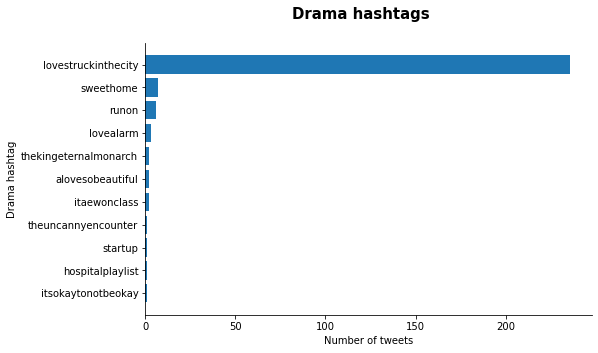

In [25]:
#Counting the number of times a drama's
#hashtag was used in the tweets
dramas_by_hashtag = df.drama.value_counts().sort_values(ascending = True)

#Creating the bar plot
fig, ax = plt.subplots(figsize = (8,5))
ax.barh(dramas_by_hashtag.index, dramas_by_hashtag)

#Axis formatting
ax.set_ylabel('Drama hashtag')
ax.set_xlabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('Drama hashtags', fontsize = 15, fontweight = 'bold')
plt.savefig('drama_hashtags.png', dpi =300)
plt.show()

# Which dramas were mentioned in the tweets, and how many times?

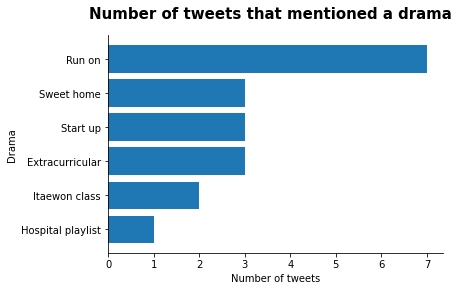

In [26]:
#Counting the number of mentions
drama_in_tweet_df = df.loc[df.tweet_text_drama == True]
drama_text_group = drama_in_tweet_df.groupby('drama_in_tweet', as_index = False)['tweet_id'].count()
drama_text_group.rename(columns = {'tweet_id': 'num_tweets'}, inplace = True)
drama_text_group = drama_text_group.sort_values('num_tweets', ascending = True)

#Creating the bar plot
fig, ax = plt.subplots()
ax.barh(drama_text_group.drama_in_tweet, drama_text_group.num_tweets)

#Axis formatting
ax.set_ylabel('Drama')
ax.set_xlabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('Number of tweets that mentioned a drama', fontsize = 15, fontweight = 'bold')
plt.savefig('drama_in_tweets.png', dpi = 300)
plt.show()

### ***How many different emojis are used in tweets?***

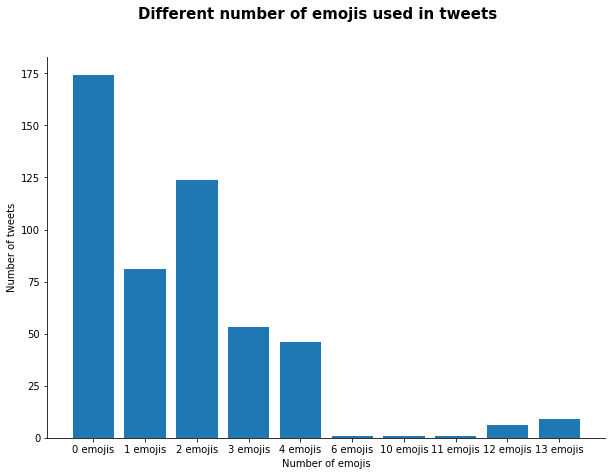

In [27]:
#Creating a dataframe with the number of emojis 
#in each tweet
emoji_count = df.groupby('total_emojis', as_index = False)['tweet_text'].count()

#Renaming the 'tweet_text' column to 'num_tweets'
emoji_count.rename(columns = {'tweet_text': 'num_tweets'})
emoji_count['total_emojis'] = emoji_count['total_emojis'].astype('str')

#Adding 'emojis' to the number of emojis
emoji_count['total_emojis'] = emoji_count['total_emojis'].apply(lambda x: x + ' emojis')

#Creating the bar plot
fig, ax = plt.subplots(figsize = (10,7))
ax.bar(emoji_count['total_emojis'], emoji_count['tweet_text'])

#Axis formatting 
ax.set_xlabel('Number of emojis')
ax.set_ylabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('Different number of emojis used in tweets', fontsize = 15, fontweight = 'bold')
plt.savefig('emojis_in_tweets.png', dpi = 300)
plt.show()

### ***How many tweets used the #kdrama or #koreandrama***?

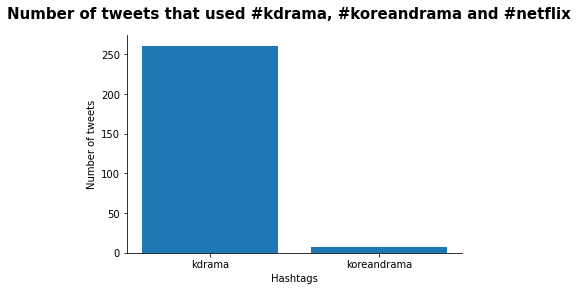

In [28]:
#Getting the number of hashtags of the tweets
hashtag_count = df[['kdrama', 'koreandrama']].sum()

#Creating the bar plot
fig, ax = plt.subplots(figsize = (6, 4))
ax.bar(hashtag_count.index, hashtag_count)

#Axis formatting
ax.set_xlabel('Hashtags')
ax.set_ylabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('Number of tweets that used #kdrama, #koreandrama and #netflix', fontsize = 15, fontweight = 'bold')
plt.show()

'#kdrama' was used more often than '#koreandrama.' However, because the API did not return all of the tweet text, this does not completely represent all of the hashtags used. 

### ***How tweets contained positive, negative and neutral emojis?***

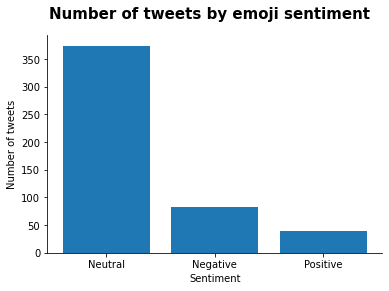

In [29]:
#Counting the sentiment of the tweets
emoji_sentiment = df['emoji_sentiment'].value_counts()

#Creating the bar graph
fig, ax = plt.subplots()
ax.bar(emoji_sentiment.index, emoji_sentiment)

#Axis formatting
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Sentiment')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting a title
fig.suptitle('Number of tweets by emoji sentiment', fontsize = 15, fontweight = 'bold')
plt.savefig('emoji_sentiment.png', dpi = 300)
plt.show()

### ***What was the sentiment of the tweets?***

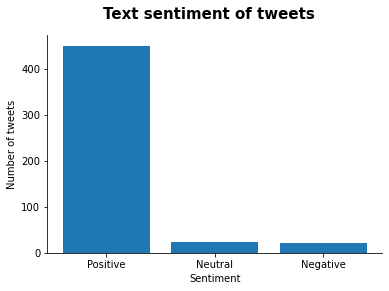

In [30]:
#Counting the sentiment
sentiment_count = df['word_sentiment'].value_counts()

#Creating the bar plot
fig, ax = plt.subplots()
ax.bar(sentiment_count.index, sentiment_count)

#Axis formatting
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('Text sentiment of tweets', fontsize = 15, fontweight = 'bold')
plt.savefig('text_sentiment.png', dpi = 300)
plt.show()

### ***Number of tweets each day***

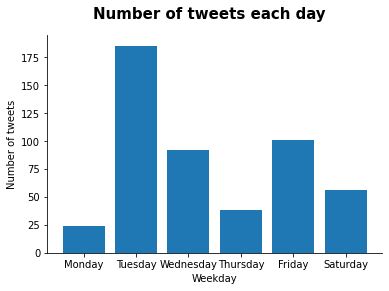

In [31]:
#Creating a dataframe with the number of tweets per day
tweets_by_day = df.groupby(['day', 'day_number'], as_index = False)['tweet_id'].count()
tweets_by_day = tweets_by_day.sort_values('day_number')
tweets_by_day.rename(columns = {'tweet_id': 'num_tweets'}, inplace = True)

#Creating the bar plot
fig, ax = plt.subplots()
ax.bar(tweets_by_day['day'], tweets_by_day['num_tweets'])

#Axis formatting 
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of tweets')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting a title
fig.suptitle('Number of tweets each day', fontsize = 15, fontweight = 'bold')
plt.savefig('tweets_per_day.png', dpi = 300)
plt.show()

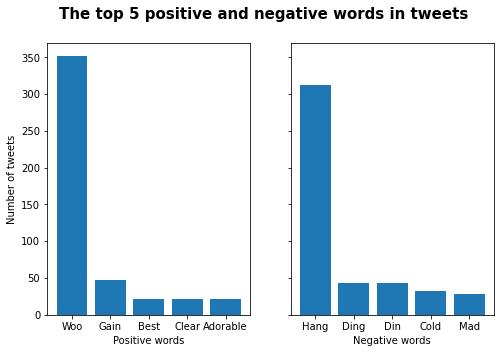

In [32]:
with open('positive-words.txt', 'r') as positive_file:
    positive_words = [line.strip() for line in positive_file.readlines()[31:]]

with open('negative-words.txt', 'r') as negative_file:
    negative_words = [line.strip() for line in negative_file.readlines()[31:]]

#Getting the count of positive words 
#and negative words used in all of the tweets
positive_words = get_word_counts(positive_words)
negative_words = get_word_counts(negative_words)

#Converting the dictionaries to a series
#and sorting the values in descending order
positive_series = pd.Series(positive_words)
positive_series = positive_series.sort_values(ascending = False)
negative_series = pd.Series(negative_words)
negative_series = negative_series.sort_values(ascending = False)

#Creating the bar plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,5), sharey = True)
ax1.bar(positive_series.head().index, positive_series.head())
ax2.bar(negative_series.head().index, negative_series.head())

#Axis formatting
ax1.set_xlabel('Positive words')
ax1.set_ylabel('Number of tweets')
ax2.set_xlabel('Negative words')
ax2.set_ylabel('')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)

#Setting the title
fig.suptitle('The top 5 positive and negative words in tweets', fontsize = 15, fontweight = 'bold')
plt.show()

The 'positive-words.txt' and 'negative-words.txt' used in this notebook are from:

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews."<br/>
&nbsp;&nbsp;&nbsp;&nbsp;Proceedings of the ACM SIGKDD International Conference on Knowledge<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle,<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;Washington, USA,

Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;and Comparing Opinions on the Web." Proceedings of the 14th<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;International World Wide Web conference (WWW-2005), May 10-14,<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;2005, Chiba, Japan.<br/>